In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import gc
import cPickle as pickle
import fastparquet

In [3]:
data=fastparquet.ParquetFile("../input/train_test.parq").to_pandas()

In [4]:
data.describe().T

count        mean         std         min  \
air_store_id                428593.0  414.000000  239.311792    0.000000   
visit_date                  428593.0  258.000000  149.244940    0.000000   
visitors                    252108.0    2.802788    0.807726    0.693147   
geo1_store_count            428593.0  272.544029  186.169951   14.000000   
geo1_visitors_count         428593.0  158.657276  148.763060    0.000000   
geo1_visitors_mean          396216.0    2.804147    0.216664    1.354025   
geo2_store_count            428593.0   41.576598   30.850748    2.000000   
geo2_visitors_count         428593.0   24.539304   24.734308    0.000000   
geo2_visitors_mean          391700.0    2.803253    0.343859    0.693147   
station_store_count         428593.0  260.078408  193.333135    2.000000   
station_visitors_count      428593.0  151.030119  150.496598    0.000000   
station_visitors_mean       395625.0    2.804620    0.254730    0.693147   
genre_name_store_count      428593.0  127.550060   62.061709    2.000000   
genre_name_visitors_count   428593.0   74.709417   56.241349    0.000000   
genre_name_visitors_mean    395279.0    2.806691    0.222878    0.693147   
TMAX                        428593.0   19.311073    8.417433  -10.600000   
TMIN                        428593.0   11.036964    8.443923  -22.500000   
TAVG                        428593.0   14.803888    8.184934  -15.400000   
PRCP                        140858.0  123.878433  168.803711    5.000000   
day_of_week_store_count     428593.0  829.000000    0.000000  829.000000   
day_of_week_visitors_count  428593.0  487.636364  253.819471    0.000000   
day_of_week_visitors_mean   396262.0    2.808927    0.179764    2.353138   
holiday                     428593.0    0.067698    0.251228    0.000000   
is_rain                     428593.0    0.328652    0.469724    0.000000   

                                   25%         50%         75%          max  
air_store_id                207.000000  414.000000  621.000000   828.000000  
visit_date                  129.000000  258.000000  387.000000   516.000000  
visitors                      2.302585    2.890372    3.401197     6.777647  
geo1_store_count             74.000000  444.000000  444.000000   444.000000  
geo1_visitors_count          33.000000  112.000000  315.000000   425.000000  
geo1_visitors_mean            2.651771    2.789400    2.937641     4.150264  
geo2_store_count             17.000000   39.000000   64.000000   103.000000  
geo2_visitors_count           6.000000   17.000000   37.000000   101.000000  
geo2_visitors_mean            2.605946    2.797153    3.005990     5.123964  
station_store_count          76.000000  440.000000  440.000000   440.000000  
station_visitors_count       19.000000  100.000000  304.000000   421.000000  
station_visitors_mean         2.655698    2.794452    2.945694     4.700480  
genre_name_store_count       79.000000  108.000000  181.000000   197.000000  
genre_name_visitors_count    27.000000   61.000000  123.000000   189.000000  
genre_name_visitors_mean      2.643957    2.789963    2.961680     5.129899  
TMAX                         12.400000   19.400000   26.299999    38.299999  
TMIN                          3.800000   10.500000   17.900000    28.700001  
TAVG                          7.900000   14.800000   21.700001    32.400002  
PRCP                         15.000000   61.000000  170.000000  1890.000000  
day_of_week_store_count     829.000000  829.000000  829.000000   829.000000  
day_of_week_visitors_count  274.000000  596.000000  727.000000   799.000000  
day_of_week_visitors_mean     2.668155    2.794935    2.948514     3.205025  
holiday                       0.000000    0.000000    0.000000     1.000000  
is_rain                       0.000000    0.000000    1.000000     1.000000

In [10]:
def nancorr2(a,b):
    idx0=(~np.isnan(a))
    idx=idx0 & (~np.isnan(b))
    a=a[idx].flatten().astype(np.float64);b=b[idx].flatten().astype(np.float64)
    return np.corrcoef(a,b)[0,1],idx.sum()/float(idx0.sum())
def lag_v(v,lag=1): #assume v is same order as data
    tmpdf=data[['air_store_id','visit_date']].copy()
    tmpdf2=tmpdf.copy()
    tmpdf2['v']=v
    tmpdf2['visit_date']=tmpdf2['visit_date']+lag
    df=pd.merge(tmpdf,tmpdf2,how="left",on=['air_store_id','visit_date'])
    return df['v'].values
    
def lag_y(lag=1):
    return lag_v(data['visitors'].values,lag=lag)
def ma(period=3):
    s=0
    sd=0.0
    for i in range(period):
        a=lag_y(i)
        ind=np.isnan(a)
        sd+= ~ind
        a[ind]=0
        s+=a
    sd[sd<period//2]=np.nan
    return s/(sd+1e-10)
def lag_ma(lag=1,period=3):
    return lag_v(ma(period=period),lag=lag)
def season_ma(period=3):
    s=0
    sd=0.0
    for i in range(period):
        a=lag_y(i*7)
        ind=np.isnan(a)
        sd+= ~ind
        a[ind]=np.nan
        s+=a
    sd[sd<period//2]=0        
    return s/(sd+1e-10)
def lag_season_ma(lag=1,period=3):
    return lag_v(season_ma(period=period),lag=lag*7)
def ind_y(fun):
    y=data['visitors'].values
    v=fun(y).astype(np.float32)
    v[np.isnan(y)]=np.nan
    return v

In [6]:
data['visitor_lag7']=lag_y(7)
data['visitor_lag14']=lag_y(14)
data['visitor_lag28']=lag_y(28)
data['visitor_lag91']=lag_y(91)
data['visitor_lag182']=lag_y(182)
data['visitor_lag364']=lag_y(364)

In [7]:
for i in [2,4,7,14,28,56,112,224]:
    data['visitor_ma{}'.format(i)]=ma(period=i)

In [8]:
for i in [1,2,3,4,8,16,32]:
    data['visitor_sma{}'.format(i)]=season_ma(period=i)

In [9]:
for col in data.columns:
    if data[col].dtype==np.float64:
        data[col]=data[col].astype(np.float32)

In [10]:
fastparquet.write('../input/train_test_v2.parq',data,compression='SNAPPY')

In [4]:
data=fastparquet.ParquetFile('../input/train_test_v2.parq').to_pandas()

# visitor count

In [12]:
data['visitors_minus_ma28']=data['visitors']-data['visitor_ma28']
data['visitors_divid_ma28']=data['visitors']/data['visitor_ma28']

In [13]:
def f(data,col):
    df=data[data['visitors']<2]
    newcol='{}_count_y1'.format(col)
    if col=='all':
        s1=df[['visit_date','visitors']].groupby(['visit_date']).count()['visitors']
        s=data[['visit_date','visitors']].groupby(['visit_date']).count()['visitors']
        m=(s1/s).to_dict()
        data[newcol]=data['visit_date'].apply(lambda u: m[u])
        return data
    else:
        s1=df[['visit_date',col,'visitors']].groupby(['visit_date',col]).count()['visitors']
        s=data[['visit_date',col,'visitors']].groupby(['visit_date',col]).count()['visitors']
        m=(s1/s).to_dict()
        data[newcol]=data[['visit_date',col]].apply(lambda u: m[tuple(u.values)],axis=1)
        return data
for col in ['all','geo1','station','geo2']:
    data=f(data,col)

In [14]:
def f(data,col):
    df=data[(data['visitors']>=2) & (data['visitors']<3)]
    newcol='{}_count_y2'.format(col)
    if col=='all':
        s1=df[['visit_date','visitors']].groupby(['visit_date']).count()['visitors']
        s=data[['visit_date','visitors']].groupby(['visit_date']).count()['visitors']
        m=(s1/s).to_dict()
        data[newcol]=data['visit_date'].apply(lambda u: m[u])
        return data
    else:
        s1=df[['visit_date',col,'visitors']].groupby(['visit_date',col]).count()['visitors']
        s=data[['visit_date',col,'visitors']].groupby(['visit_date',col]).count()['visitors']
        m=(s1/s).to_dict()
        data[newcol]=data[['visit_date',col]].apply(lambda u: m[tuple(u.values)],axis=1)
        return data
for col in ['all','geo1','station','geo2']:
    data=f(data,col)

In [15]:
def f(data,col):
    df=data[(data['visitors']>=3) & (data['visitors']<4)]
    newcol='{}_count_y3'.format(col)
    if col=='all':
        s1=df[['visit_date','visitors']].groupby(['visit_date']).count()['visitors']
        s=data[['visit_date','visitors']].groupby(['visit_date']).count()['visitors']
        m=(s1/s).to_dict()
        data[newcol]=data['visit_date'].apply(lambda u: m[u])
        return data
    else:
        s1=df[['visit_date',col,'visitors']].groupby(['visit_date',col]).count()['visitors']
        s=data[['visit_date',col,'visitors']].groupby(['visit_date',col]).count()['visitors']
        m=(s1/s).to_dict()
        data[newcol]=data[['visit_date',col]].apply(lambda u: m[tuple(u.values)],axis=1)
        return data
for col in ['all','geo1','station','geo2']:
    data=f(data,col)

In [16]:
def f(data,col):
    df=data[(data['visitors']>=4) & (data['visitors']<5)]
    newcol='{}_count_y4'.format(col)
    if col=='all':
        s1=df[['visit_date','visitors']].groupby(['visit_date']).count()['visitors']
        s=data[['visit_date','visitors']].groupby(['visit_date']).count()['visitors']
        m=(s1/s).to_dict()
        data[newcol]=data['visit_date'].apply(lambda u: m[u])
        return data
    else:
        s1=df[['visit_date',col,'visitors']].groupby(['visit_date',col]).count()['visitors']
        s=data[['visit_date',col,'visitors']].groupby(['visit_date',col]).count()['visitors']
        m=(s1/s).to_dict()
        data[newcol]=data[['visit_date',col]].apply(lambda u: m[tuple(u.values)],axis=1)
        return data
for col in ['all','geo1','station','geo2']:
    data=f(data,col)

In [17]:
def f(data,col):
    df=data[(data['visitors']>=5) & (data['visitors']<500)]
    newcol='{}_count_y5'.format(col)
    if col=='all':
        s1=df[['visit_date','visitors']].groupby(['visit_date']).count()['visitors']
        s=data[['visit_date','visitors']].groupby(['visit_date']).count()['visitors']
        m=(s1/s).to_dict()
        data[newcol]=data['visit_date'].apply(lambda u: m[u])
        return data
    else:
        s1=df[['visit_date',col,'visitors']].groupby(['visit_date',col]).count()['visitors']
        s=data[['visit_date',col,'visitors']].groupby(['visit_date',col]).count()['visitors']
        m=(s1/s).to_dict()
        data[newcol]=data[['visit_date',col]].apply(lambda u: m[tuple(u.values)],axis=1)
        return data
for col in ['all','geo1','station','geo2']:
    data=f(data,col)

In [18]:
data.head()

air_store_id  visit_date  visitors   geo1  geo1_store_count  \
index                                                                
0                 0           0       NaN  Tōkyō               444   
1                 0           1       NaN  Tōkyō               444   
2                 0           2       NaN  Tōkyō               444   
3                 0           3       NaN  Tōkyō               444   
4                 0           4       NaN  Tōkyō               444   

       geo1_visitors_count  geo1_visitors_mean     geo2  geo2_store_count  \
index                                                                       
0                       20            2.620946  Chiyoda                22   
1                       18            2.811538  Chiyoda                22   
2                       27            3.030371  Chiyoda                22   
3                       68            2.735346  Chiyoda                22   
4                      114            2.639541  Chiyoda                22   

       geo2_visitors_count      ...        station_count_y3 geo2_count_y3  \
index                           ...                                         
0                        1      ...                0.300000      1.000000   
1                        1      ...                0.388889      1.000000   
2                        1      ...                0.370370      1.000000   
3                        3      ...                0.343284      0.666667   
4                        6      ...                0.312500      0.666667   

       all_count_y4  geo1_count_y4  station_count_y4 geo2_count_y4  \
index                                                                
0          0.125000       0.150000          0.150000           NaN   
1          0.095238       0.055556          0.055556           NaN   
2          0.123457       0.111111          0.111111           NaN   
3          0.044586       0.029412          0.029851           NaN   
4          0.017316       0.008772          0.008929           NaN   

       all_count_y5  geo1_count_y5  station_count_y5  geo2_count_y5  
index                                                                
0               NaN            NaN               NaN            NaN  
1               NaN            NaN               NaN            NaN  
2               NaN            NaN               NaN            NaN  
3               NaN            NaN               NaN            NaN  
4               NaN            NaN               NaN            NaN  

[5 rows x 72 columns]

In [19]:
data.describe().T

count        mean         std         min  \
air_store_id                428593.0  414.000000  239.311792    0.000000   
visit_date                  428593.0  258.000000  149.244940    0.000000   
visitors                    252108.0    2.802788    0.807726    0.693147   
geo1_store_count            428593.0  272.544029  186.169951   14.000000   
geo1_visitors_count         428593.0  158.657276  148.763060    0.000000   
geo1_visitors_mean          396216.0    2.804147    0.216664    1.354025   
geo2_store_count            428593.0   41.576598   30.850748    2.000000   
geo2_visitors_count         428593.0   24.539304   24.734308    0.000000   
geo2_visitors_mean          391700.0    2.803253    0.343859    0.693147   
station_store_count         428593.0  260.078408  193.333135    2.000000   
station_visitors_count      428593.0  151.030119  150.496598    0.000000   
station_visitors_mean       395625.0    2.804620    0.254730    0.693147   
genre_name_store_count      428593.0  127.550060   62.061709    2.000000   
genre_name_visitors_count   428593.0   74.709417   56.241349    0.000000   
genre_name_visitors_mean    395279.0    2.806691    0.222878    0.693147   
TMAX                        428593.0   19.311073    8.417433  -10.600000   
TMIN                        428593.0   11.036964    8.443923  -22.500000   
TAVG                        428593.0   14.803888    8.184934  -15.400000   
PRCP                        140858.0  123.878433  168.803711    5.000000   
day_of_week_store_count     428593.0  829.000000    0.000000  829.000000   
day_of_week_visitors_count  428593.0  487.636364  253.819471    0.000000   
day_of_week_visitors_mean   396262.0    2.808927    0.179764    2.353138   
holiday                     428593.0    0.067698    0.251228    0.000000   
is_rain                     428593.0    0.328652    0.469724    0.000000   
visitor_lag7                252108.0    2.802788    0.807726    0.693147   
visitor_lag14               252108.0    2.802788    0.807726    0.693147   
visitor_lag28               252108.0    2.802788    0.807726    0.693147   
visitor_lag91               214769.0    2.797594    0.803939    0.693147   
visitor_lag182              153020.0    2.795519    0.800231    0.693147   
visitor_lag364               39739.0    2.852021    0.793312    0.693147   
...                              ...         ...         ...         ...   
visitor_ma224               215824.0    2.795313    0.548402    0.751810   
visitor_sma1                252108.0    2.802788    0.807726    0.693147   
visitor_sma2                229263.0    2.834325    0.713535    0.693147   
visitor_sma3                211374.0    2.855476    0.674883    0.693147   
visitor_sma4                195954.0    2.872328    0.651609    0.693147   
visitor_sma8                148267.0    2.917469    0.604593    0.693147   
visitor_sma16                84550.0    2.972189    0.561236    0.794514   
visitor_sma32                31926.0    3.027951    0.533754    1.341810   
visitors_minus_ma28         239100.0    0.000942    0.570402   -3.263732   
visitors_divid_ma28         239100.0    1.000466    0.221875    0.175175   
all_count_y1                396262.0    0.168404    0.052577    0.034130   
geo1_count_y1               385016.0    0.174963    0.070225    0.017544   
station_count_y1            369507.0    0.181921    0.089297    0.024390   
geo2_count_y1               321451.0    0.207285    0.132643    0.016393   
all_count_y2                396262.0    0.391968    0.052946    0.251046   
geo1_count_y2               395331.0    0.393384    0.084927    0.066667   
station_count_y2            387148.0    0.400947    0.102205    0.055556   
geo2_count_y2               369730.0    0.416313    0.156805    0.043478   
all_count_y3                396262.0    0.393275    0.067299    0.220447   
geo1_count_y3               395198.0    0.392754    0.094757    0.062500   
station_count_y3            387001.0    0.400603    0.111987    0.055556   
geo

In [20]:
pd.to_datetime('2017-4-23')-pd.to_datetime('2017-5-31')

Timedelta('-38 days +00:00:00')

In [21]:
str([ u for u in data.columns if 'visitor' in u and 'count' not in u])

"['visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28']"

In [22]:
columns=['visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean',
         'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 
         'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182',
         'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 
         'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 
         'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 
         'visitor_sma32']+ \
        ['visitors_minus_ma28', 'visitors_divid_ma28'] +\
        ['all_count_y1','geo1_count_y1','station_count_y1','geo2_count_y1'] +\
        ['all_count_y2','geo1_count_y2','station_count_y2','geo2_count_y2'] +\
        ['all_count_y3','geo1_count_y3','station_count_y3','geo2_count_y3'] +\
        ['all_count_y4','geo1_count_y4','station_count_y4','geo2_count_y4'] +\
        ['all_count_y5','geo1_count_y5','station_count_y5','geo2_count_y5'] +\
        [u'TMAX', u'TMIN', u'TAVG', u'PRCP', u'holiday']

In [23]:
data[columns].head()

visitors  geo1_visitors_mean  geo2_visitors_mean  \
index                                                     
0           NaN            2.620946            3.555348   
1           NaN            2.811538            3.784190   
2           NaN            3.030371            3.433987   
3           NaN            2.735346            3.231744   
4           NaN            2.639541            2.903008   

       station_visitors_mean  genre_name_visitors_mean  \
index                                                    
0                   2.620946                  3.009525   
1                   2.811538                  2.615095   
2                   3.030371                  2.684705   
3                   2.730037                  2.599179   
4                   2.640511                  2.614342   

       day_of_week_visitors_mean  visitor_lag7  visitor_lag14  visitor_lag28  \
index                                                                          
0                       2.632437           NaN            NaN            NaN   
1                       3.077320           NaN            NaN            NaN   
2                       3.091436           NaN            NaN            NaN   
3                       2.829584           NaN            NaN            NaN   
4                       2.639654           NaN            NaN            NaN   

       visitor_lag91   ...     geo2_count_y4  all_count_y5  geo1_count_y5  \
index                  ...                                                  
0                NaN   ...               NaN           NaN            NaN   
1                NaN   ...               NaN           NaN            NaN   
2                NaN   ...               NaN           NaN            NaN   
3                NaN   ...               NaN           NaN            NaN   
4                NaN   ...               NaN           NaN            NaN   

       station_count_y5  geo2_count_y5       TMAX  TMIN  TAVG  PRCP  holiday  
index                                                                         
0                   NaN            NaN  12.100000   2.6   7.3   NaN      1.0  
1                   NaN            NaN  13.400000   2.6   7.4   NaN      1.0  
2                   NaN            NaN  16.200001   3.0   9.8   NaN      1.0  
3                   NaN            NaN  15.200000   4.4   9.9   NaN      0.0  
4                   NaN            NaN  15.400000   5.1  10.8   NaN      0.0  

[5 rows x 54 columns]

In [24]:
data.shape,829*517

((428593, 72), 428593)

In [25]:
lstdata=[]
for col in columns:
    df=data[['air_store_id','visit_date',col]]
    df2=pd.pivot_table(df,columns='visit_date', index='air_store_id',values=col,dropna=False)
    df2=df2[sorted(df2.columns)].sort_index()
    assert df2.shape==(829, 517), col+' '+str(df2.shape)
    lstdata.append(df2.values)
    

In [26]:
arr=np.array(lstdata).astype(np.float32)

In [27]:
arr.dtype,arr.nbytes/1024.**2

(dtype('float32'), 88.28743743896484)

In [28]:
arr.shape

(54, 829, 517)

In [29]:
len(columns)

54

In [30]:
np.savez('../input/train_test.npy',columns=columns,data=arr)

In [31]:
data[columns].corr()

visitors  geo1_visitors_mean  geo2_visitors_mean  \
visitors                   1.000000            0.263495            0.401427   
geo1_visitors_mean         0.263495            1.000000            0.633702   
geo2_visitors_mean         0.401427            0.633702            1.000000   
station_visitors_mean      0.303294            0.853041            0.740854   
genre_name_visitors_mean   0.261585            0.666705            0.434833   
day_of_week_visitors_mean  0.220962            0.822514            0.517691   
visitor_lag7               0.631976            0.189445            0.264276   
visitor_lag14              0.618641            0.168177            0.246589   
visitor_lag28              0.606905            0.164786            0.243177   
visitor_lag91              0.583205            0.168240            0.238155   
visitor_lag182             0.565105            0.161688            0.228188   
visitor_lag364             0.548474            0.212525            0.253544   
visitor_ma2                0.893440            0.207960            0.315365   
visitor_ma4                0.781282            0.093686            0.212327   
visitor_ma7                0.748364            0.070609            0.191051   
visitor_ma14               0.722153            0.059465            0.179426   
visitor_ma28               0.705294            0.047832            0.168231   
visitor_ma56               0.692952            0.038875            0.160949   
visitor_ma112              0.682154            0.034729            0.157193   
visitor_ma224              0.668341            0.025987            0.148732   
visitor_sma1               1.000000            0.263495            0.401427   
visitor_sma2               0.903264            0.252732            0.372592   
visitor_sma3               0.864975            0.242688            0.356971   
visitor_sma4               0.843244            0.236486            0.345902   
visitor_sma8               0.804334            0.225476            0.325808   
visitor_sma16              0.769287            0.219620            0.304833   
visitor_sma32              0.754687            0.217595            0.281231   
visitors_minus_ma28        0.706378            0.326003            0.377763   
visitors_divid_ma28        0.690225            0.308106            0.361635   
all_count_y1              -0.209937           -0.778703           -0.492843   
geo1_count_y1             -0.215784           -0.846200           -0.521187   
station_count_y1          -0.225430           -0.660229           -0.569842   
geo2_count_y1             -0.282047           -0.424937           -0.818210   
all_count_y2              -0.188119           -0.667045           -0.416878   
geo1_count_y2             -0.153584           -0.523698           -0.330096   
station_count_y2          -0.135631           -0.417539           -0.304866   
geo2_count_y2             -0.126702           -0.268159           -0.322038   
all_count_y3               0.213107            0.787314            0.496415   
geo1_count_y3              0.218447            0.800776            0.511738   
station_count_y3           0.220705            0.661963            0.537596   
geo2_count_y3              0.262370            0.457814            0.710608   
all_count_y4               0.196907            0.711329            0.445894   
geo1_count_y4              0.188775            0.725862            0.436958   
station_count_y4           0.184216            0.609876            0.466353   
geo2_count_y4              0.208682            0.405533            0.650393   
all_count_y5               0.047099            0.113569            0.080489   
geo1_count_y5              0.098692            0.362631            0.174940   
station_count_y5           0.088734            0.297399            0.197854   
geo2_count_y5              0.162357            0.127592            0.562580   
TMAX                      -0.000812            0.025431            0.018564  

In [33]:
data[columns].min()

visitors                      0.693147
geo1_visitors_mean            1.354025
geo2_visitors_mean            0.693147
station_visitors_mean         0.693147
genre_name_visitors_mean      0.693147
day_of_week_visitors_mean     2.353138
visitor_lag7                  0.693147
visitor_lag14                 0.693147
visitor_lag28                 0.693147
visitor_lag91                 0.693147
visitor_lag182                0.693147
visitor_lag364                0.693147
visitor_ma2                   0.693147
visitor_ma4                   0.693147
visitor_ma7                   0.693147
visitor_ma14                  0.693147
visitor_ma28                  0.693147
visitor_ma56                  0.706663
visitor_ma112                 0.745711
visitor_ma224                 0.751810
visitor_sma1                  0.693147
visitor_sma2                  0.693147
visitor_sma3                  0.693147
visitor_sma4                  0.693147
visitor_sma8                  0.693147
visitor_sma16            

# visitor count by store

In [3]:
def read_data(fname="../input/train_test.npy.npz"):
    a = np.load(fname)
    cols = a['columns']
    arr = a['data']
    return cols, arr

In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
import rrvf_data

In [6]:
columns,data=read_data()
data=np.rollaxis(data,0,3)
len(columns),data.shape

(54, (829, 517, 54))

In [7]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [8]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [10]:
newcolumns=[]
newdata=[]
END_DATE=478-7

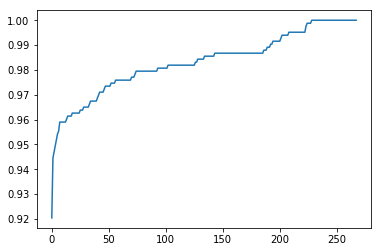

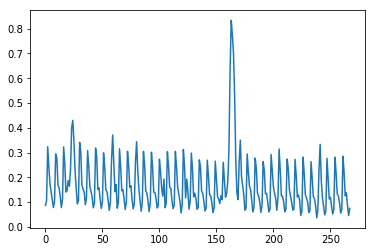

a
wd          
0   0.939935
1   0.911223
2   0.711876
3   0.751935
4   0.846997
5   0.865721
6   0.896299

In [11]:
def get_y_nan_index(_rawy):
    def g(rawy):
        ind=(~np.isnan(rawy)).astype(np.int32)
        for s in ind:
            i=np.where(s>0)[0][0]
            s[i:]=1
        return ind
    rawy=_rawy[:,203:END_DATE]
    yind=g(rawy)    
    plt.plot(yind.mean(0));plt.show()
    plt.plot(1.0*np.isnan(rawy).sum(0)/yind.sum(0));plt.show()
    def g(rawy,yind):
        ind=~np.isnan(rawy)
        df=pd.DataFrame({'a':1.0*ind.sum(0)/yind.sum(0)})
        df['date']=rrvf_data.idx_to_date(df.index+203)
        df['wd']=df.index%7
        return df
    display(g(rawy,yind).groupby('wd').mean())
    def g(i, rawy,_yind):
        ind= (~np.isnan(rawy[i])).astype(np.float)
        yind=_yind[i]
        df=pd.DataFrame({'a':ind,'ind':yind})
        df['date']=rrvf_data.idx_to_date(df.index+203)
        df['wd']=df.index%7
        df=df[df['ind']>0]

        df=df.groupby('wd').mean()
        df['a']=(df['a']/df['a'].mean()).astype(np.float32)
        df['store']=i
        return df['a'].to_dict()
    ret={}
    for i in range(rawy.shape[0]):
        ret[i]=g(i,rawy,yind)
    return ret
mdict=get_y_nan_index(rawy)

In [12]:
def make_series(mdict):
    s=np.zeros_like(rawy)
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            s[i,j]= mdict[i][j%7] #if j in mdict[i] else np.nan
    return s

In [13]:
newcolumns.append('store_nan_week_ratio')
newdata.append(make_series(mdict))

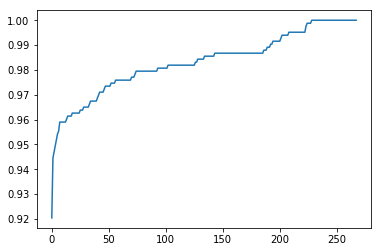

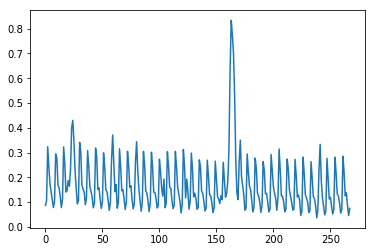

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less_equal


In [14]:
def get_y_nan_index(_rawy):
    def g(rawy):
        ind=(~np.isnan(rawy)).astype(np.int32)
        for s in ind:
            i=np.where(s>0)[0][0]
            s[i:]=1
        return ind
    rawy=_rawy[:,203:END_DATE]
    yind=g(rawy)    
    plt.plot(yind.mean(0));plt.show()
    plt.plot(1.0*np.isnan(rawy).sum(0)/yind.sum(0));plt.show()

    def g(i, rawy,_yind):
        ind= ((rawy[i]>0) &(rawy[i]<=1)).astype(np.float)
        yind=_yind[i]
        df=pd.DataFrame({'a':ind,'ind':yind})
        df['date']=rrvf_data.idx_to_date(df.index+203)
        df['wd']=df.index%7
        df=df[ (df['ind']>0)]

        df=df.groupby('wd').mean()
        df['a']=(df['a']).astype(np.float32)
        df['store']=i
        return df['a'].to_dict()
    ret={}
    for i in range(rawy.shape[0]):
        ret[i]=g(i,rawy,yind)
    return ret
mdict=get_y_nan_index(rawy)

In [15]:
newcolumns.append('store_y1_week_ratio')
newdata.append(make_series(mdict))

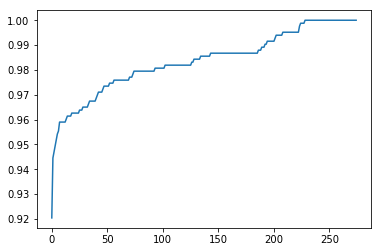

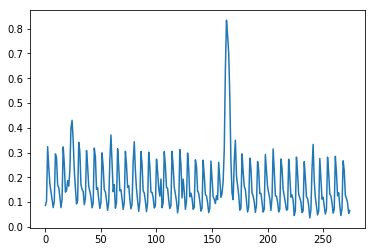

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less_equal


In [16]:
def get_y_nan_index(_rawy):
    def g(rawy):
        ind=(~np.isnan(rawy)).astype(np.int32)
        for s in ind:
            i=np.where(s>0)[0][0]
            s[i:]=1
        return ind
    rawy=_rawy[:,203:478]
    yind=g(rawy)    
    plt.plot(yind.mean(0));plt.show()
    plt.plot(1.0*np.isnan(rawy).sum(0)/yind.sum(0));plt.show()

    def g(i, rawy,_yind):
        ind= ((rawy[i]>1) &(rawy[i]<=2)).astype(np.float)
        yind=_yind[i]
        df=pd.DataFrame({'a':ind,'ind':yind})
        df['date']=rrvf_data.idx_to_date(df.index+203)
        df['wd']=df.index%7
        df=df[ (df['ind']>0)]

        df=df.groupby('wd').mean()
        df['a']=(df['a']).astype(np.float32)
        df['store']=i
        return df['a'].to_dict()
    ret={}
    for i in range(rawy.shape[0]):
        ret[i]=g(i,rawy,yind)
    return ret
mdict=get_y_nan_index(rawy)

In [17]:
newcolumns.append('store_y2_week_ratio')
newdata.append(make_series(mdict))

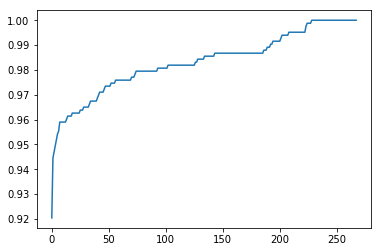

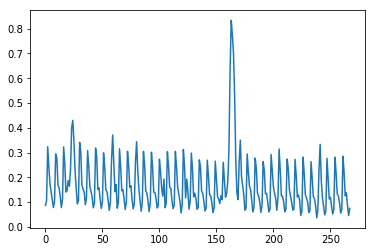

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less_equal


In [18]:
def get_y_nan_index(_rawy):
    def g(rawy):
        ind=(~np.isnan(rawy)).astype(np.int32)
        for s in ind:
            i=np.where(s>0)[0][0]
            s[i:]=1
        return ind
    rawy=_rawy[:,203:END_DATE]
    yind=g(rawy)    
    plt.plot(yind.mean(0));plt.show()
    plt.plot(1.0*np.isnan(rawy).sum(0)/yind.sum(0));plt.show()

    def g(i, rawy,_yind):
        ind= ((rawy[i]>3) &(rawy[i]<=4)).astype(np.float)
        yind=_yind[i]
        df=pd.DataFrame({'a':ind,'ind':yind})
        df['date']=rrvf_data.idx_to_date(df.index+203)
        df['wd']=df.index%7
        df=df[ (df['ind']>0)]

        df=df.groupby('wd').mean()
        df['a']=(df['a']).astype(np.float32)
        df['store']=i
        return df['a'].to_dict()
    ret={}
    for i in range(rawy.shape[0]):
        ret[i]=g(i,rawy,yind)
    return ret
mdict=get_y_nan_index(rawy)

In [19]:
newcolumns.append('store_y4_week_ratio')
newdata.append(make_series(mdict))

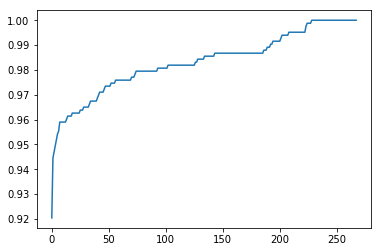

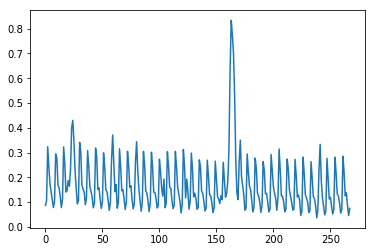

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less_equal


In [21]:
def get_y_nan_index(_rawy):
    def g(rawy):
        ind=(~np.isnan(rawy)).astype(np.int32)
        for s in ind:
            i=np.where(s>0)[0][0]
            s[i:]=1
        return ind
    rawy=_rawy[:,203:END_DATE]
    yind=g(rawy)    
    plt.plot(yind.mean(0));plt.show()
    plt.plot(1.0*np.isnan(rawy).sum(0)/yind.sum(0));plt.show()

    def g(i, rawy,_yind):
        ind= ((rawy[i]>4) &(rawy[i]<=20000)).astype(np.float)
        yind=_yind[i]
        df=pd.DataFrame({'a':ind,'ind':yind})
        df['date']=rrvf_data.idx_to_date(df.index+203)
        df['wd']=df.index%7
        df=df[ (df['ind']>0)]

        df=df.groupby('wd').mean()
        df['a']=(df['a']).astype(np.float32)
        df['store']=i
        return df['a'].to_dict()
    ret={}
    for i in range(rawy.shape[0]):
        ret[i]=g(i,rawy,yind)
    return ret
mdict=get_y_nan_index(rawy)

In [22]:
newcolumns.append('store_y4_week_ratio')
newdata.append(make_series(mdict))

In [23]:
data.shape

(829, 517, 54)

In [24]:
str(newcolumns)

"['store_nan_week_ratio', 'store_y1_week_ratio', 'store_y2_week_ratio', 'store_y4_week_ratio', 'store_y4_week_ratio']"

In [25]:
newdata2=np.round(np.rollaxis(np.array(newdata),0,3),2)

In [26]:
newdata3=np.rollaxis(np.concatenate([data,newdata2],axis=-1),2,0)
newdata3.shape,newdata3.dtype

((59, 829, 517), dtype('float32'))

In [27]:
newcolumns3=np.array(list(columns)+newcolumns)
len(newcolumns3)

59

In [28]:
np.savez('../input/train_test_ext.npy',columns=newcolumns3,data=newdata3)